<h4>Import Packages </h4>

In [1]:
from astropy.io import fits
from reproject import reproject_exact
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
from numpy.polynomial import Polynomial
from astropy.visualization import PercentileInterval, ImageNormalize
import numpy as np
from astropy.stats import sigma_clipped_stats
from photutils.segmentation import detect_sources
from scipy import ndimage
from sklearn.linear_model import HuberRegressor
from astropy.table import Table
import matplotlib.gridspec as gridspec
import warnings
from astropy.wcs import WCS
import os
import glob
from reproject import reproject_interp
from reproject.mosaicking import find_optimal_celestial_wcs, reproject_and_coadd

#courtesty of Dr. Wong
def make_star_mask(array, clip=4, minpix=10):
    # Determine stats
    mean, _, std = sigma_clipped_stats(array)
    print('Data mean, std:', mean, std)
    threshold = clip * std
    struct = ndimage.generate_binary_structure(2, 2)
    # Find bright objects with at least 10 pixels
    segm0 = detect_sources(array-mean, threshold, npixels=minpix)
    # Expand the mask and plot as contour
    starmask = ndimage.binary_dilation(segm0.data, structure=struct).astype(segm0.data.dtype)
    return starmask

#courtesty of stack overflow
def xy2hist(xarr, yarr, log=True, bins=[100,100]):
    if log:
        valid = (xarr > 0) & (yarr > 0)
        x = np.log10(xarr[valid])
        y = np.log10(yarr[valid])
    else:
        valid = np.isfinite(xarr+yarr)
        x = xarr[valid]
        y = yarr[valid]
    # Histogram the data
    hh, locx, locy = np.histogram2d(x, y, bins=bins)
    # Get the bin value z for each (x,y) point
    z = np.array([hh[np.argmax(a<=locx[1:]),np.argmax(b<=locy[1:])] for a,b in zip(x,y)])
    # Plot the highest density points last
    idx = z.argsort()
    x, y, z = x[idx], y[idx], z[idx]
    if log:
        z = np.log10(z)
    #x_real = xarr[valid][idx]
    #y_real = yarr[valid][idx]
    return x, y, z, hh, locx, locy

In [ ]:
#set this to "Ha" or "SII"
#DEMCELS only has data for Bands around HA and SII
wavelength = 'Ha'
#set bins
bins= 1000 #fairly arbitrary

#some stuff for later
if wavelength == 'Ha':
    muse_mosaic_path = 'N44_mos_ha_mom0_demcels.fits.gz'
    demcels_mosaic_path = 'LMC_c39_T11.N662.t800.dr01.fits'
    outfile = 'DEMCELS_Mosaic_Halpha_cor.fits'
    tile_path = 'ha'
    corrected_name = 'ha'
if wavelength == 'SII':
    muse_mosaic_path = 'N44_mos_sii_mom0_demcels.fits.gz'
    demcels_mosaic_path = 'LMC_c39_T11.N673.t800.dr01.fits'
    outfile = 'DEMCELS_Mosaic_SII_cor.fits'
    tile_path = 'sii'
    corrected_name = 'sii'

<h4> Histogram and rescale DEMCELS, we want it 0-centered.</h4>

In [ ]:
#get muse data
muse_mosaic = fits.open(muse_mosaic_path)[0]
muse_data = muse_mosaic.data
muse_header = muse_mosaic.header
muse_data_flat = muse_data.flatten()

#get demcels data in MUSE field
demcels_mosaic  = fits.open(demcels_mosaic_path)[0]
demcels_header = demcels_mosaic.header
demcels_data, footprint = reproject_exact(demcels_mosaic, muse_header)
demcels_data_flat = demcels_data.flatten()

#plot
fig, ax = plt.subplots(figsize=(12,12),ncols=2,gridspec_kw={'wspace':0.4})
#muse
im0 = ax[0].imshow(muse_data, origin='lower', cmap='cubehelix',norm=ImageNormalize(muse_data, interval=PercentileInterval(99)))
ax[0].set_title('MUSE')
cax0 = make_axes_locatable(ax[0]).append_axes('right', size='5%', pad=0.1)
fig.colorbar(im0, cax=cax0, orientation='vertical')
#demcels
im1 = ax[1].imshow(demcels_data,origin='lower',cmap='cubehelix',norm=ImageNormalize(demcels_data, interval=PercentileInterval(99)))
ax[1].set_title('DEMCELS')
cax1 = make_axes_locatable(ax[1]).append_axes('right', size='5%', pad=0.1)
fig.colorbar(im1, cax=cax1, orientation='vertical')
plt.show()

#histogram demcels data
counts, bin_edges = np.histogram(demcels_data_flat,bins=bins)
peak_bin = np.argmax(counts)
peak_value = (bin_edges[peak_bin] + bin_edges[peak_bin +1])/2

fig, ax = plt.subplots(figsize=(6,6))
ax.hist(demcels_data_flat,bins=bins)
ymin,ymax=plt.ylim()
ax.vlines(peak_value,ymin=0,ymax=ymax,color='red',linestyle='dashed',alpha=0.5)
ax.set_title('DEMCELS Histogram')
ax.set_xlabel('Flux')
ax.set_ylabel('Counts')
ax.set_xlim(0,1500)
ax.text(0.4,0.7,f'Most Common Value:{peak_value:.2f}',fontsize='large',transform=plt.gca().transAxes,bbox=dict(facecolor='None',edgecolor='black'))
plt.show()

#correct data
demcels_data_corrected = demcels_data - peak_value
demcels_data_flat_corrected = demcels_data_flat - peak_value

fig, ax = plt.subplots(figsize=(12,12),ncols=2,gridspec_kw={'wspace':0.4})
#demcels corrected
im0 = ax[0].imshow(demcels_data_corrected, origin='lower', cmap='cubehelix',norm=ImageNormalize(demcels_data_corrected, 
                                                                                           interval=PercentileInterval(99)))
ax[0].set_title('DEMCELS Corrected')
cax0 = make_axes_locatable(ax[0]).append_axes('right', size='5%', pad=0.1)
fig.colorbar(im0, cax=cax0, orientation='vertical')
#demcels corrected negative mask
red_pix = np.zeros((demcels_data_corrected.shape[0],demcels_data_corrected.shape[1],4))
red_pix[demcels_data_corrected<0] = [1,0,0,1]
im1 = ax[1].imshow(demcels_data_corrected,origin='lower',cmap='cubehelix',norm=ImageNormalize(demcels_data_corrected, 
                                                                                                   interval=PercentileInterval(99)))
ax[1].imshow(red_pix,origin='lower')
ax[1].set_title('DEMCELS Corrected, Negatives Highlighted')
cax1 = make_axes_locatable(ax[1]).append_axes('right', size='5%', pad=0.1)
fig.colorbar(im1, cax=cax1, orientation='vertical')
plt.show()

#write out corrected demcels
demcels_cor_HDU = fits.PrimaryHDU(demcels_data_corrected,muse_header)
demcels_cor_HDU.writeto(outfile,overwrite=True)

<h4> Slopes and Int Comparison. There should be a nice ridge line comparing flux of MUSE vs DEMCELS. </h4>

In [ ]:
warnings.filterwarnings('ignore')
#we will save data about the fitting for each tile comparison
table_new=Table(names=('Cube','Slope','Intercept','SlopeUncertainty','InterceptUncertainty'))
rows = [10,20,30,40,50,60,70,80]
for j in rows:
    tile_num = j
    for i in range(8):
        print(f'Running Comparison for Cube {tile_num}')
        tile_hdu = fits.open('OB'+str(tile_num)[0]+'_N44_DATACUBE_FINAL_'+str(tile_num)+
                             '_corGAUSS.'+tile_path+'_mom0_demcels.fits.gz')[0]
        musedata = tile_hdu.data
        dmc_hdu  = fits.open(outfile)[0]
        dmcdata, footprint = reproject_exact(dmc_hdu, tile_hdu.header)
        #fits.writeto('demcels_reprojected_tiles/demcels_tile_'+str(tile_num)+'.ha.fits', dmcdata, tile_hdu.header, overwrite=True)
        
        fig = plt.figure(figsize=(14,14))
        gs = gridspec.GridSpec(2,2,figure=fig,height_ratios=[2,1])
        
        ax1 = fig.add_subplot(gs[1,0])
        im0 = ax1.imshow(musedata, origin='lower', norm=ImageNormalize(musedata, interval=PercentileInterval(98)))
        ax1.set_title('MUSE Filtered')
        cax0 = make_axes_locatable(ax1).append_axes('right', size='5%', pad=0.1)
        fig.colorbar(im0, cax=cax0, orientation='vertical')
        if tile_num ==74:
            musemask = make_star_mask(musedata,clip=3)
        else:
            musemask = make_star_mask(musedata)
        ax1.contour(musemask, origin='lower', colors='r')
    
        ax2 = fig.add_subplot(gs[1,1])
        im1 = ax2.imshow(dmcdata,origin='lower',norm=ImageNormalize(dmcdata, interval=PercentileInterval(98)))
        ax2.set_title('DEMCELS Filtered')
        cax1 = make_axes_locatable(ax2).append_axes('right', size='5%', pad=0.1)
        fig.colorbar(im1, cax=cax1, orientation='vertical')
        dmcmask = make_star_mask(dmcdata)
        ax2.contour(dmcmask, origin='lower', colors='orange')
    
        xdata = dmcdata[musemask+dmcmask==0].flatten()
        ydata = musedata[musemask+dmcmask==0].flatten()
    
        ax3 = fig.add_subplot(gs[0,:])
        #valid points only
        select=(xdata>0)&(ydata>0)
        #histogram + scatter
        xnew, ynew, znew, hh, locx, locy = xy2hist(xdata[select],ydata[select], bins=[300,300], log=False)
        ax3.scatter(xnew, ynew, c=znew, alpha=0.2, marker='.',cmap='jet')
        #polynomial
        coeff,cov_matrix = np.polyfit(xdata[select], ydata[select], 1,cov=True)
        slope, intercept = coeff
        slope_uncertainty = (cov_matrix[0,0])
        intercept_uncertainty = (cov_matrix[1,1])
        x_vals = np.linspace(min(xdata[select]),max(xdata[select]),1000)
        ax3.plot(x_vals,np.polyval(coeff,x_vals), c='magenta', linestyle='--', label='Polynomial Fit')
        #plotting stuff
        ax3.set_xlim(left=0)
        ax3.set_ylim(bottom=0)
        ax3.set_xlabel('DeMCELS image')
        ax3.set_ylabel('MUSE image')
        ax3.legend(loc='upper right')
        ax3.set_title(f'{tile_path} Cube {tile_num}')
        ax3.text(0.02,0.98,f'{slope}x+{intercept}',color='black',bbox=dict(facecolor='None',edgecolor='black'),
                horizontalalignment='left',verticalalignment='top',transform=plt.gca().transAxes,fontsize='large')
        plt.savefig(f'MUSE_vs_DEMCELS_cube_{tile_num}_{tile_path}.png')
        table_new.add_row([tile_num,round(slope,3),round(intercept,3),round(slope_uncertainty,3),round(intercept_uncertainty,3)])
        tile_num+=1
table_new.write(f'slopes_and_int_{tile_path}.csv',format='csv',overwrite=True)
table_new

<h4> Quick Comparison of Slopes and Intercepts w/ Uncertainties </h4>

In [ ]:
#compare slopes and intercepts across all tiles + uncertainties
slopes_table = Table.read(f'slopes_and_int_{tile_path}.csv',format='csv')
fig = plt.figure(figsize=(10,10))
plt.errorbar(slopes_table['Cube'],slopes_table['Slope'],yerr=slopes_table['SlopeUncertainty'],fmt='.',
             color='black',markersize=7,capsize=5)
#these lines loosely define the rows of tiles. Just makes it easier to quickly read the plot
plt.axvline(x=7, c='red', linestyle = '--')
plt.text(9,100*2.37, "Row 1", color='red',fontsize=12)
plt.axvline(x=17, c='red', linestyle = '--')
plt.text(19,100*2.37, "Row 2", color='red',fontsize=12)
plt.axvline(x=27, c='red', linestyle = '--')
plt.text(29,100*2.37, "Row 3", color='red',fontsize=12)
plt.axvline(x=37, c='red', linestyle = '--')
plt.text(39,100*2.37, "Row 4", color='red',fontsize=12)
plt.axvline(x=47, c='red', linestyle = '--')
plt.text(49,100*2.37, "Row 5", color='red',fontsize=12)
plt.axvline(x=57, c='red', linestyle = '--')
plt.text(59,100*2.37, "Row 6", color='red',fontsize=12)
plt.axvline(x=67, c='red', linestyle = '--')
plt.text(69,100*2.37, "Row 7", color='red',fontsize=12)
plt.axvline(x=77, c='red', linestyle = '--')
plt.text(79,100*2.37, "Row 8", color='red',fontsize=12)
plt.axvline(x=87, c='red', linestyle = '--')
plt.title('Slopes of MUSE vs DeMCELS Ridge Line')
plt.xlabel('Cube Number')
plt.ylabel('Slope')
plt.legend()
plt.xlim(7,90)
plt.savefig('Slope_comparisons')
plt.show()
#plotting intercepts
fig = plt.figure(figsize=(10,10))
plt.errorbar(slopes_table['Cube'],slopes_table['Intercept'],yerr=slopes_table['InterceptUncertainty'],fmt='.',
             color='black',markersize=7,capsize=5)
plt.axvline(x=7, c='red', linestyle = '--')
plt.text(9,150*150, "Row 1", color='red',fontsize=12)
plt.axvline(x=17, c='red', linestyle = '--')
plt.text(19,150*150, "Row 2", color='red',fontsize=12)
plt.axvline(x=27, c='red', linestyle = '--')
plt.text(29,150*150, "Row 3", color='red',fontsize=12)
plt.axvline(x=37, c='red', linestyle = '--')
plt.text(39,150*150, "Row 4", color='red',fontsize=12)
plt.axvline(x=47, c='red', linestyle = '--')
plt.text(49,150*150, "Row 5", color='red',fontsize=12)
plt.axvline(x=57, c='red', linestyle = '--')
plt.text(59,150*150, "Row 6", color='red',fontsize=12)
plt.axvline(x=67, c='red', linestyle = '--')
plt.text(69,150*150, "Row 7", color='red',fontsize=12)
plt.axvline(x=77, c='red', linestyle = '--')
plt.text(79,150*150, "Row 8", color='red',fontsize=12)
plt.axvline(x=87, c='red', linestyle = '--')
plt.title('Intercepts of MUSE vs DeMCELS Ridge Line')
plt.xlabel('Cube Number')
plt.ylabel('Intercept')
plt.xlim(7,90)
plt.savefig('Int_comparisons')

<h4> Rescale MUSE Tiles</h4>

In [ ]:
rows = [10,20,30,40,50,60,70,80]
for j in rows:
    tile_num = j
    for i in range(8):
        print(f'Rescale Tile {tile_num}')
        #muse tiles
        tile_hdu = fits.open('OB'+str(tile_num)[0]+'_N44_DATACUBE_FINAL_'+str(tile_num)+
                             '_corGAUSS.'+tile_path+'_mom0_demcels.fits.gz')[0]
        tile_data = tile_hdu.data
        tile_header = tile_hdu.header
        
        #demcels correction values
        demcels_slopes_and_int_table = Table.read(f'slopes_and_int_{tile_path}.csv',format='csv')
        tile_min = j
        tile_max = j+7
        for cube,slope,intercept,_,_ in slopes_table:
            if cube == tile_num:
                demcels_slope = slope
                demcels_intercept = intercept
        #average slope across row
        demcels_row_slopes = [slope for cube,slope,_,_,_ in slopes_table if (tile_min <= cube <= tile_max)]
        demcels_row_slopes_average = sum(demcels_row_slopes)/len(demcels_row_slopes)
        #demcels_row_intercepts = [intercept for cube,slope,intercept,_,_ in slopes_table if (tile_min <= cube <= tile_max)]
        #demcels_row_intercepts_average = sum(demcels_row_intercepts)/len(demcels_row_intercepts)
        print(f'Average slope for Row {str(tile_num)[0]}:{demcels_row_slopes_average}')
        #correct the tiles
        tile_data_corrected = tile_data - demcels_intercept
        tile_data_corrected = tile_data_corrected / demcels_row_slopes_average
        #write out
        rescaled_muse_hdu = fits.PrimaryHDU(tile_data_corrected,tile_hdu.header)
        rescaled_muse_hdu.writeto(f'MUSE_{tile_num}_{corrected_name}_fluxCorrected.fits',overwrite=True)
        
        #plot for reference
        fig = plt.figure(figsize=(14,14))
        gs = gridspec.GridSpec(2,2,figure=fig,height_ratios=[2,1])
        #muse
        ax1 = fig.add_subplot(gs[1,0])
        im0 = ax1.imshow(tile_data, origin='lower', norm=ImageNormalize(tile_data, interval=PercentileInterval(98)))
        ax1.set_title(f'MUSE Original {tile_num}')
        cax0 = make_axes_locatable(ax1).append_axes('right', size='5%', pad=0.1)
        fig.colorbar(im0, cax=cax0, orientation='vertical')
        #muse rescaled
        ax2 = fig.add_subplot(gs[1,1])
        im1 = ax2.imshow(tile_data_corrected,origin='lower',norm=ImageNormalize(tile_data_corrected, interval=PercentileInterval(98)))
        ax2.set_title(f'MUSE Rescaled {tile_num}')
        cax1 = make_axes_locatable(ax2).append_axes('right', size='5%', pad=0.1)
        fig.colorbar(im1, cax=cax1, orientation='vertical')
        
        tile_num+=1

<h4> Re-Create the Mosaic </h4>

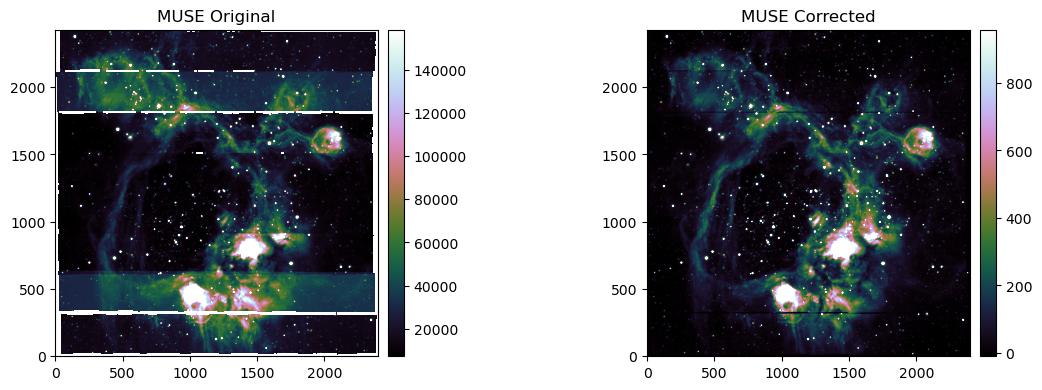

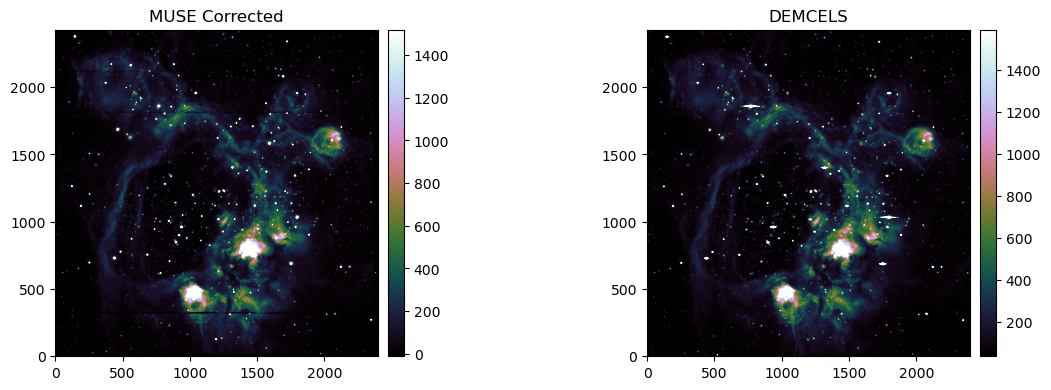

In [10]:
#get the tiles
rescaled_muse_tiles = sorted(glob.glob('MUSE_??_'+corrected_name+'_fluxCorrected.fits'))
hdulist = []
for tile in rescaled_muse_tiles:
    hdulist.append(fits.open(tile)[0])
#find wcs
wcs_out, shape_out = find_optimal_celestial_wcs(hdulist)
#combine tiles into mosaic
arr, footprint = reproject_and_coadd(hdulist,
                wcs_out, shape_out=shape_out,
                reproject_function=reproject_interp)
hd2d = wcs_out.to_header()
hd2d['datamin'] = np.nanmin(arr)
hd2d['datamax'] = np.nanmax(arr)
fits.writeto(f'MUSE_Mosaic_{corrected_name}_corrected.fits', arr, hd2d, overwrite=True)

#plot
fig = plt.figure(figsize=(14,14))
gs = gridspec.GridSpec(2,2,figure=fig,height_ratios=[2,1])
#muse
ax1 = fig.add_subplot(gs[1,0])
im0 = ax1.imshow(muse_data, origin='lower', cmap='cubehelix',norm=ImageNormalize(muse_data, interval=PercentileInterval(98)))
ax1.set_title('MUSE Original')
cax0 = make_axes_locatable(ax1).append_axes('right', size='5%', pad=0.1)
fig.colorbar(im0, cax=cax0, orientation='vertical')
#muse rescaled
ax2 = fig.add_subplot(gs[1,1])
im1 = ax2.imshow(arr,origin='lower',cmap='cubehelix',norm=ImageNormalize(arr, interval=PercentileInterval(98)))
ax2.set_title('MUSE Corrected')
cax1 = make_axes_locatable(ax2).append_axes('right', size='5%', pad=0.1)
fig.colorbar(im1, cax=cax1, orientation='vertical')

#compare with demcels
fig = plt.figure(figsize=(14,14))
gs = gridspec.GridSpec(2,2,figure=fig,height_ratios=[2,1])
#muse
ax1 = fig.add_subplot(gs[1,0])
im0 = ax1.imshow(arr, origin='lower', cmap='cubehelix',norm=ImageNormalize(arr, interval=PercentileInterval(99)))
ax1.set_title('MUSE Corrected')
cax0 = make_axes_locatable(ax1).append_axes('right', size='5%', pad=0.1)
fig.colorbar(im0, cax=cax0, orientation='vertical')
#muse rescaled
ax2 = fig.add_subplot(gs[1,1])
im1 = ax2.imshow(demcels_data,origin='lower',cmap='cubehelix',norm=ImageNormalize(demcels_data, interval=PercentileInterval(99)))
ax2.set_title('DEMCELS')
cax1 = make_axes_locatable(ax2).append_axes('right', size='5%', pad=0.1)
fig.colorbar(im1, cax=cax1, orientation='vertical')
plt.show()

In [ ]:
#save nice image
ax = plt.subplot(projection=wcs_out)
norm = ImageNormalize(arr, interval=PercentileInterval(99))
im = ax.imshow(arr, cmap='cubehelix', origin='lower', norm=norm)
plt.colorbar(im)
plt.savefig(f'MUSE_Mosaic_{corrected_name}_corrected', bbox_inches='tight')
plt.show()